In [1]:
# user defined R installation
import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #path to your R installation
%load_ext autoreload
%autoreload 2



import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import globalenv
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

import sys
sys.path.append('../')
from causaloptim_py.causaloptim_python import run_experiment, extract_prob_dict
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, entropy_of_array

from entropy_bounds.utils import entropy_dist

import matplotlib.pyplot as plt
import seaborn as sns
import math




# Load R packages
#igraph = importr('igraph')
causaloptim = importr('causaloptim')
base = importr('base')

In [15]:
### Simulation ###
results = []

for b_X_Y in np.arange(-5, 5, 0.005):  # 2000 samples: (-5, 5, 0.005)
    sim = simulate_deterministic_data_with_probabilistic_ate(
        b_X_Y= b_X_Y
    )

    df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})
    prob_dict = extract_prob_dict(df)

    graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
    leftside = [1, 0, 0, 0]
    latent = [0, 0, 0, 1]
    nvals = [2, 2, 2, 2]
    rlconnect = [0, 0, 0, 0]
    monotone = [0, 0, 0, 0]

    bounds = run_experiment(graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict)
    bound_lower = float(bounds[0][0])
    bound_upper = float(bounds[1][0])
    bounds_valid = bound_lower <= sim['ATE_true'] <= bound_upper

    results.append({
        'seed': sim['seed'],
        'intercept_X': sim['intercept_X'],
        'intercept_Y': sim['intercept_Y'],
        'b_X_Y': sim['b_X_Y'],
        'b_Z': sim['b_Z'],
        'b_U_X': sim['b_U_X'],
        'b_U_Y': sim['b_U_Y'],
        'ATE_true': sim['ATE_true'],
        'p_Y1': sim['p_Y1'],
        'p_Y0': sim['p_Y0'],
        'Z': sim['Z'],
        'U': sim['U'],
        'X': sim['X'],
        'Y': sim['Y'],
        'entropy_Y': entropy_of_array(sim['Y']),
        'entropy_X': entropy_of_array(sim['X']),
        'entropy_Z': entropy_of_array(sim['Z']),
        'entropy_U': entropy_of_array(sim['U']),
        'corr_X_Y': np.corrcoef(sim['X'], sim['Y'])[0, 1],
        'corr_X_Z': np.corrcoef(sim['X'], sim['Z'])[0, 1],
        'corr_Y_Z': np.corrcoef(sim['Y'], sim['Z'])[0, 1],
        'causaloptim_bound_lower': bound_lower,
        'causaloptim_bound_upper': bound_upper,
        'causaloptim_bound_width': bound_upper - bound_lower,
        'causaloptim_bounds_valid': bounds_valid
    })

df_results = pd.DataFrame(results)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



In [18]:
df_results.to_pickle('binaryIV_results.pkl')

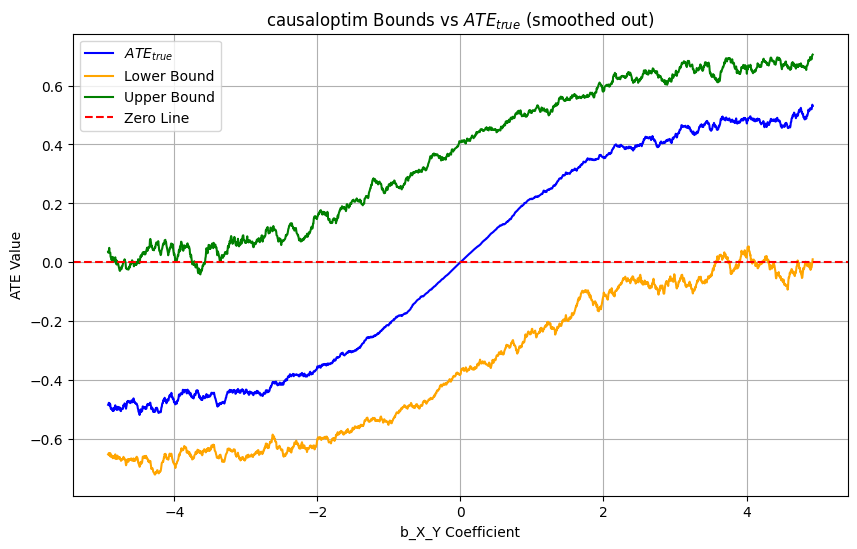

In [26]:
# Smoothen the data using a rolling average
df_results['ATE_true_smooth'] = df_results['ATE_true'].rolling(window=30, center=True).mean()
df_results['bound_lower_smooth'] = df_results['causaloptim_bound_lower'].rolling(window=30, center=True).mean()
df_results['bound_upper_smooth'] = df_results['causaloptim_bound_upper'].rolling(window=30, center=True).mean()

# Plot the smoothed data
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')
sns.lineplot(data=df_results, x='b_X_Y', y='bound_lower_smooth', label='Lower Bound', color='orange')
sns.lineplot(data=df_results, x='b_X_Y', y='bound_upper_smooth', label='Upper Bound', color='green')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('causaloptim Bounds vs $ATE_{true}$ (smoothed out)')
plt.xlabel('b_X_Y Coefficient')
plt.ylabel('ATE Value')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
### Average bound width 
# Calculate the average bound width
average_bound_width = df_results['causaloptim_bound_width'].mean()
print(f"Average Bound Width: {average_bound_width}")
# average bound width with b_X_Y in [-4, 4]
average_bound_width_b_X_Y = df_results[(df_results['b_X_Y'] >= -4) & (df_results['b_X_Y'] <= 4)]['causaloptim_bound_width'].mean()
print(f"Average Bound Width (b_X_Y in [-4, 4]): {average_bound_width_b_X_Y}")

Average Bound Width: 0.7266014031779089
Average Bound Width (b_X_Y in [-4, 4]): 0.7340604502406378


In [ ]:
valid_df.entropy_U.describe()
## entropy of confounder has max of 0.7

count    1995.000000
mean        0.692158
std         0.001410
min         0.680292
25%         0.691795
50%         0.692755
75%         0.693019
max         0.693147
Name: entropy_U, dtype: float64

In [21]:
# Perform OLS regression using statsmodels
import statsmodels.api as sm
valid_df = df_results[df_results['causaloptim_bounds_valid'] == True]
# Add a constant for the intercept
valid_df['corr_X_Y_squared'] = valid_df['corr_X_Y'] ** 2
valid_df['corr_X_Z_squared'] = valid_df['corr_X_Z'] ** 2
X = sm.add_constant(valid_df[[ 'corr_X_Y_squared', 'corr_X_Z_squared', 
                              'entropy_Y', 'entropy_X']])	
y = valid_df['causaloptim_bound_width']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

ols_robust = ols_model.get_robustcov_results(cov_type='HC1')
print(ols_robust.summary())

                               OLS Regression Results                              
Dep. Variable:     causaloptim_bound_width   R-squared:                       0.844
Model:                                 OLS   Adj. R-squared:                  0.844
Method:                      Least Squares   F-statistic:                     1398.
Date:                     Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                             09:38:49   Log-Likelihood:                 2791.8
No. Observations:                     1995   AIC:                            -5574.
Df Residuals:                         1990   BIC:                            -5546.
Df Model:                                4                                         
Covariance Type:                       HC1                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

C:\Users\tmari\AppData\Local\Temp\ipykernel_296\3459086875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['corr_X_Y_squared'] = valid_df['corr_X_Y'] ** 2
C:\Users\tmari\AppData\Local\Temp\ipykernel_296\3459086875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['corr_X_Z_squared'] = valid_df['corr_X_Z'] ** 2


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming X contains only your 4 predictors + constant
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]
print(vif_data)

            feature         VIF
0             const  219.431704
1  corr_X_Y_squared    1.194470
2  corr_X_Z_squared    1.027128
3         entropy_Y    1.217476
4         entropy_X    1.063083


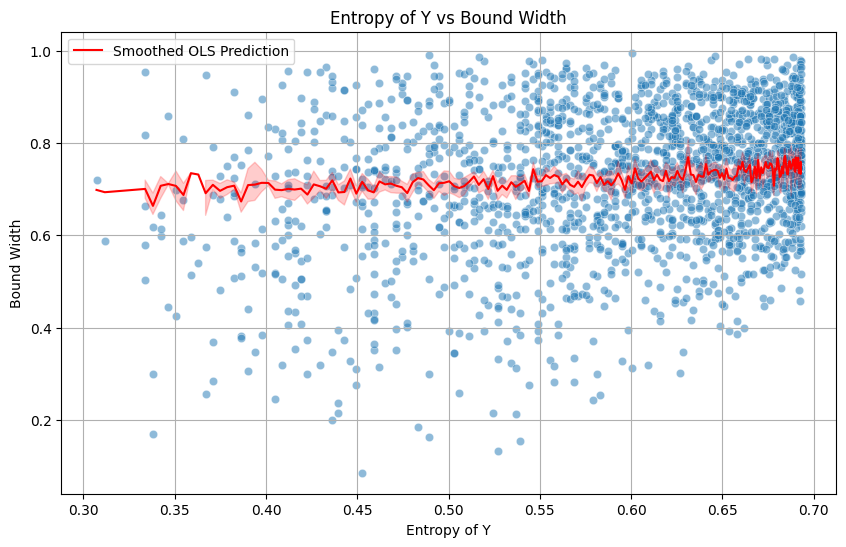

In [ ]:
### Plot entropy_Y vs bound_width
plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_df, x='entropy_Y', y='bound_width', alpha=0.5)
## Smoothen OLS prediction line
X_pred = sm.add_constant(valid_df[['corr_X_Y_squared', 'corr_X_Z_squared', 
                                     'entropy_Y', 'entropy_X']])
y_pred = ols_model.predict(X_pred)
y_pred_smooth = pd.Series(y_pred).rolling(window=30, center=True).mean()
sns.lineplot(x=valid_df['entropy_Y'], y=y_pred_smooth, color='red', label='Smoothed OLS Prediction')
plt.title('Entropy of Y vs Bound Width')
plt.xlabel('Entropy of Y')
plt.ylabel('Bound Width')
plt.grid(True)
plt.show()
## does not really add much

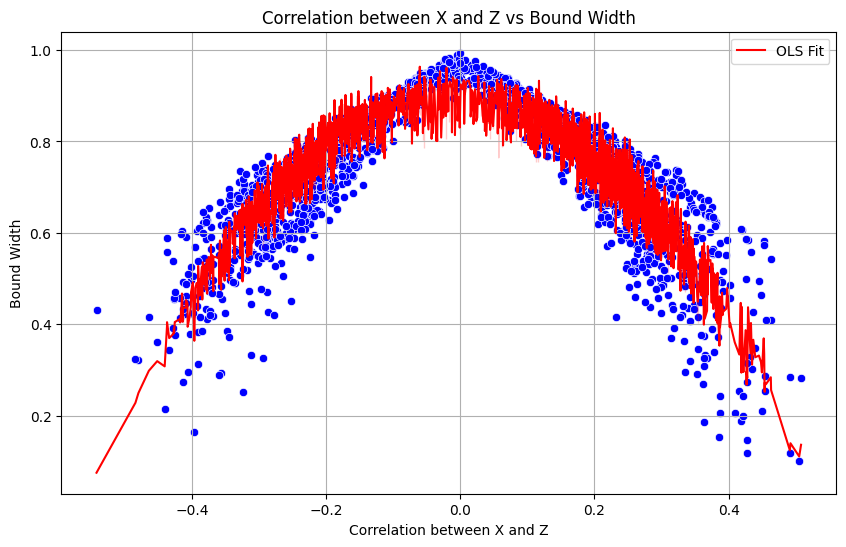

In [29]:
### Plot corr_X_Z vs bound_width
plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_df, x='corr_X_Z', y='causaloptim_bound_width', color='blue')
sns.lineplot(data=valid_df, x='corr_X_Z', y=ols_model.predict(X), color='red', label='OLS Fit')
plt.title('Correlation between X and Z vs Bound Width')
plt.xlabel('Correlation between X and Z')
plt.ylabel('Bound Width')
plt.legend()
plt.grid(True)
plt.show()

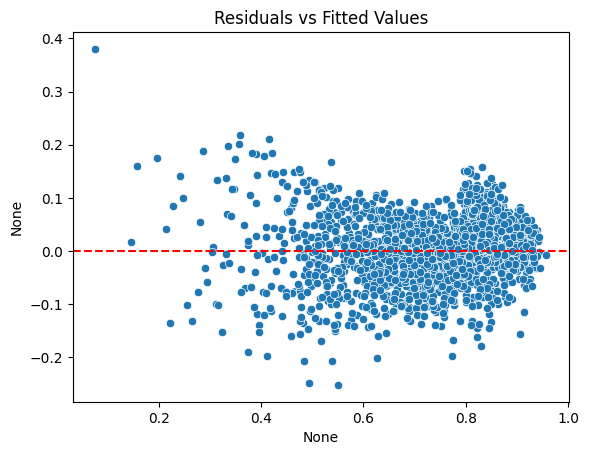

Breusch-Pagan p-value: 0.0000


In [157]:
residuals = y - ols_model.predict(X)
fitted = ols_model.predict(X)
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.show()

import statsmodels.stats.api as sms
test = sms.het_breuschpagan(residuals, X)
print(f'Breusch-Pagan p-value: {test[1]:.4f}')


C:\Users\tmari\AppData\Local\Temp\ipykernel_14548\2420919186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['bound_width_smooth'] = valid_df['bound_width'].rolling(window=100, center=True).mean()
C:\Users\tmari\AppData\Local\Temp\ipykernel_14548\2420919186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['ols_fit_smooth'] = pd.Series(ols_model.predict(X)).rolling(window=100, center=True).mean()


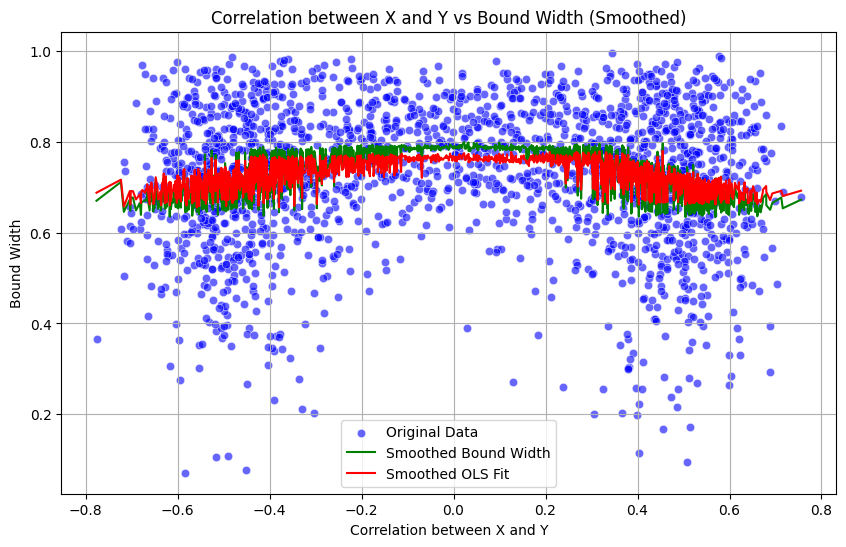

In [92]:
### Plot corr_X_Y vs bound_width (smoothed)
valid_df['bound_width_smooth'] = valid_df['bound_width'].rolling(window=100, center=True).mean()
valid_df['ols_fit_smooth'] = pd.Series(ols_model.predict(X)).rolling(window=100, center=True).mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_df, x='corr_X_Y', y='bound_width', color='blue', alpha=0.6, label='Original Data')
sns.lineplot(data=valid_df, x='corr_X_Y', y='bound_width_smooth', color='green', label='Smoothed Bound Width')
sns.lineplot(data=valid_df, x='corr_X_Y', y='ols_fit_smooth', color='red', label='Smoothed OLS Fit')
plt.title('Correlation between X and Y vs Bound Width (Smoothed)')
plt.xlabel('Correlation between X and Y')
plt.ylabel('Bound Width')
plt.legend()
plt.grid(True)
plt.show()

In [139]:
df_invalid = df_results[df_results['bounds_valid'] == False]

df_invalid

,b_X_Y,b_Z,b_U_X,b_U_Y,entropy_Y,entropy_X,entropy_Z,entropy_U,corr_X_Y,corr_X_Z,corr_Y_Z,ATE_true,bound_lower,bound_upper,bound_width,bounds_valid,ATE_true_smooth,bound_lower_smooth,bound_upper_smooth
263,-3.685,-1.410730,0.173914,-1.867159,0.477405,0.664064,0.692755,0.693019,-0.339856,-0.406763,0.147553,-0.305526,-0.255176,-0.072073,0.183104,False,-0.460214,-0.658500,-0.035277
1592,2.960,1.828598,-1.006221,0.915293,0.429585,0.687729,0.687304,0.693115,0.373313,0.387589,0.148725,0.358903,0.208383,0.330657,0.122274,False,0.449659,-0.019804,0.626856
1638,3.190,2.222435,-1.432231,1.373166,0.342313,0.680929,0.692947,0.692947,0.341992,0.523391,0.187420,0.328809,0.340616,0.131893,-0.208723,False,0.452473,-0.036595,0.655926
1717,3.585,1.756828,-1.449276,0.805597,0.486223,0.692859,0.692635,0.693019,0.455292,0.409095,0.142617,0.383388,0.227369,0.381511,0.154142,False,0.448997,0.003556,0.657005
1813,4.065,1.546003,-1.582868,1.397399,0.378712,0.692755,0.692347,0.690553,0.345087,0.357546,0.105675,0.328157,0.084615,0.267308,0.182692,False,0.452772,-0.030238,0.643235


In [140]:
from scipy.stats import entropy
from collections import Counter

# Compute the probability distribution of the array
value_counts = Counter(sim['X'])
probabilities = [count / len(sim['X']) for count in value_counts.values()]

# Compute the entropy
entropy_X = entropy(probabilities, base=2)
print(f"Entropy of sim['X']: {entropy_X}")

Entropy of sim['X']: 0.9021932572871765


In [1]:
### safe df valid to file 
# df_results.to_csv('binaryIV_causaloptim-bounds.csv', index=False)
df_results
### safe without _smooth and with causaloptim_ prefix
df_safe = df_results.copy()

# Drop columns only if they exist
columns_to_drop = ['ATE_true_smooth', 'bound_lower_smooth', 'bound_upper_smooth', 'bound_width_smooth']
df_safe = df_safe.drop(columns=[col for col in columns_to_drop if col in df_safe.columns])

# Rename columns
df_safe.rename(columns=lambda x: x.replace('bound_', 'causaloptim_bound_'), inplace=True)

df_safe.to_csv('binaryIV_causaloptim-bounds.csv', index=False)

NameError: name 'df_results' is not defined

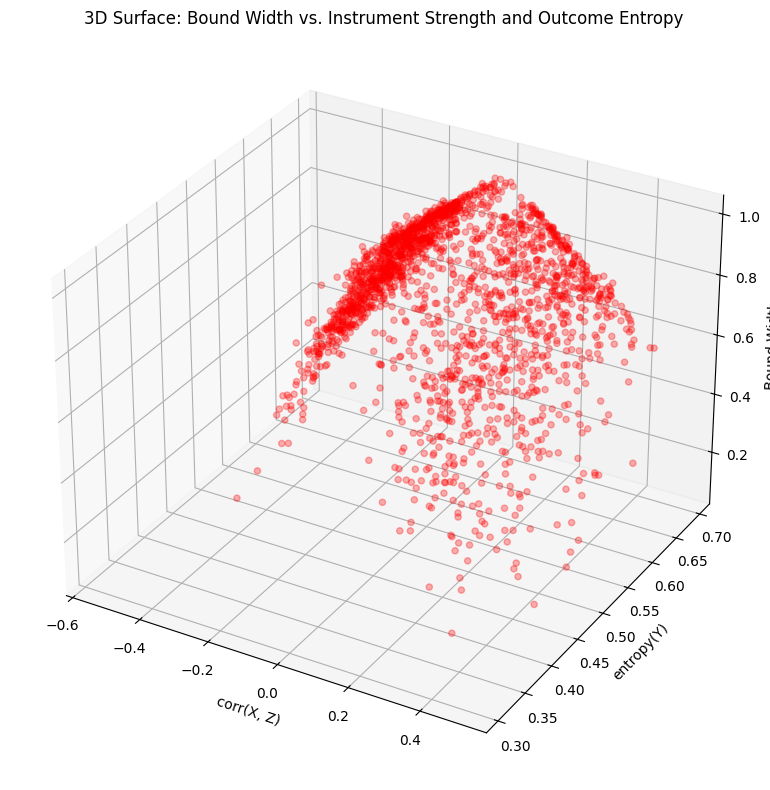

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

# Prepare the input features
df = valid_df.copy()
X = df[['corr_X_Z', 'entropy_Y']]
y = df['bound_width']

# Fit linear model (you can replace with a non-linear regressor if needed)
model = LinearRegression()
model.fit(X, y)

# Create a grid for surface
x_range = np.linspace(df['corr_X_Z'].min(), df['corr_X_Z'].max(), 50)
y_range = np.linspace(df['entropy_Y'].min(), df['entropy_Y'].max(), 50)
xx, yy = np.meshgrid(x_range, y_range)

# Predict over the grid
grid = pd.DataFrame({
    'corr_X_Z': xx.ravel(),
    'entropy_Y': yy.ravel()
})
zz = model.predict(grid).reshape(xx.shape)

# Plot
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# # Surface
# ax.plot_surface(xx, yy, zz, cmap='viridis', alpha=0.8)

# Scatter actual data points
ax.scatter(df['corr_X_Z'], df['entropy_Y'], df['bound_width'], color='red', alpha=0.3)

# Axis labels
ax.set_xlabel('corr(X, Z)')
ax.set_ylabel('entropy(Y)')
ax.set_zlabel('Bound Width')
ax.set_title('3D Surface: Bound Width vs. Instrument Strength and Outcome Entropy')

plt.tight_layout()
plt.show()


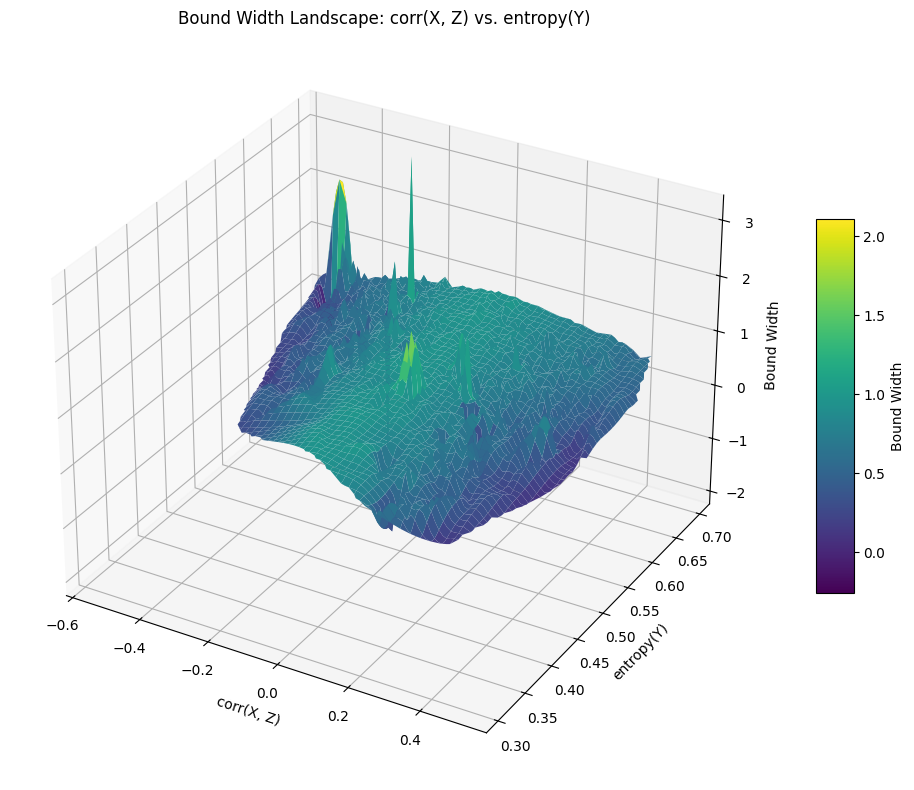

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

# Copy and clean data
df = valid_df.copy()
x = df['corr_X_Z']
y = df['entropy_Y']
z = df['bound_width']

# Create grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xx, yy = np.meshgrid(xi, yi)

# Interpolate z values (bound width) onto the grid
zz = griddata((x, y), z, (xx, yy), method='cubic')

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface
surf = ax.plot_surface(xx, yy, zz, cmap='viridis', edgecolor='none', alpha=1.0)

# Labels and title
ax.set_xlabel('corr(X, Z)')
ax.set_ylabel('entropy(Y)')
ax.set_zlabel('Bound Width')
ax.set_title('Bound Width Landscape: corr(X, Z) vs. entropy(Y)')

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Bound Width')

plt.tight_layout()
plt.show()
